In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
import itertools
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

### I.- Time series analysis

The eurozone is a monetary union of 19 member states of the European Union that have adopted the euro as their primary currency. 

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('euro-daily-hist_1999_2022.csv',index_col='Period\\Unit:',parse_dates=['Period\\Unit:'], date_parser=dateparse, dayfirst=True)
pd.set_option('display.max_columns', None)

In [3]:
df.head()

,[Australian dollar ],[Bulgarian lev ],[Brazilian real ],[Canadian dollar ],[Swiss franc ],[Chinese yuan renminbi ],[Cypriot pound ],[Czech koruna ],[Danish krone ],[Estonian kroon ],[UK pound sterling ],[Greek drachma ],[Hong Kong dollar ],[Croatian kuna ],[Hungarian forint ],[Indonesian rupiah ],[Israeli shekel ],[Indian rupee ],[Iceland krona ],[Japanese yen ],[Korean won ],[Lithuanian litas ],[Latvian lats ],[Maltese lira ],[Mexican peso ],[Malaysian ringgit ],[Norwegian krone ],[New Zealand dollar ],[Philippine peso ],[Polish zloty ],[Romanian leu ],[Russian rouble ],[Swedish krona ],[Singapore dollar ],[Slovenian tolar ],[Slovak koruna ],[Thai baht ],[Turkish lira ],[US dollar ],[South African rand ]
Period\Unit:,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-08,1.4552,1.9558,5.1583,1.3675,1.0155,6.9115,NaN,24.479,7.4372,NaN,0.83355,NaN,8.5134,7.5490,375.66,15601.96,3.5010,82.3890,139.6,134.87,1333.12,NaN,NaN,NaN,21.8729,4.5850,9.5080,1.5849,55.990,4.6437,4.9425,NaN,10.2768,1.4801,NaN,NaN,36.4880,16.0237,1.0861,15.9968
2022-04-07,1.4578,1.9558,5.1460,1.3704,1.0185,6.9448,NaN,24.512,7.4378,NaN,0.83450,NaN,8.5554,7.5562,379.26,15692.35,3.5259,82.9510,141.0,135.32,1330.92,NaN,NaN,NaN,21.9806,4.6046,9.5595,1.5816,56.114,4.6370,4.9419,NaN,10.3130,1.4848,NaN,NaN,36.5410,16.0929,1.0916,16.0520
2022-04-06,1.4431,1.9558,5.0996,1.3647,1.0187,6.9498,NaN,24.441,7.4378,NaN,0.83473,NaN,8.5617,7.5470,377.77,15683.36,3.5199,82.8343,141.4,135.30,1330.44,NaN,NaN,NaN,21.8759,4.6040,9.5523,1.5718,56.167,4.6328,4.9433,NaN,10.2855,1.4844,NaN,NaN,36.7010,16.0998,1.0923,15.9934
2022-04-05,1.4374,1.9558,5.0384,1.3647,1.0141,6.9783,NaN,24.338,7.4378,NaN,0.83490,NaN,8.5917,7.5399,370.93,15732.77,3.5152,82.6350,141.6,134.76,1330.81,NaN,NaN,NaN,21.7474,4.6185,9.5398,1.5657,56.194,4.6265,4.9438,NaN,10.2593,1.4867,NaN,NaN,36.6970,16.1500,1.0969,15.9529
2022-04-04,1.4651,1.9558,5.1162,1.3749,1.0203,7.0026,NaN,24.320,7.4385,NaN,0.83890,NaN,8.6226,7.5455,369.15,15783.89,3.5312,83.1180,141.8,135.08,1338.41,NaN,NaN,NaN,21.8200,4.6430,9.5489,1.5860,56.521,4.6375,4.9432,NaN,10.3849,1.4938,NaN,NaN,36.8940,16.1830,1.1005,16.0957


In [4]:
#printing summary of a DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6022 entries, 2022-04-08 to 1999-01-04
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   [Australian dollar ]      6022 non-null   object 
 1   [Bulgarian lev ]          5620 non-null   object 
 2   [Brazilian real ]         5754 non-null   object 
 3   [Canadian dollar ]        6022 non-null   object 
 4   [Swiss franc ]            6022 non-null   object 
 5   [Chinese yuan renminbi ]  5754 non-null   object 
 6   [Cypriot pound ]          2346 non-null   object 
 7   [Czech koruna ]           6022 non-null   object 
 8   [Danish krone ]           6022 non-null   object 
 9   [Estonian kroon ]         3130 non-null   object 
 10  [UK pound sterling ]      6022 non-null   object 
 11  [Greek drachma ]          520 non-null    object 
 12  [Hong Kong dollar ]       6022 non-null   object 
 13  [Croatian kuna ]          5754 non-null   obj

In [5]:
#df.set_index('Period\\Unit:', inplace=True)#set the index
df.index.rename('Date', inplace = True)#rename it
df.index = pd.to_datetime(df.index)#pass it to datatime

In [6]:
#Convert columns data to numeric
cols = list(df)
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')# It will replace all non-numeric values with NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6022 entries, 2022-04-08 to 1999-01-04
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   [Australian dollar ]      5960 non-null   float64
 1   [Bulgarian lev ]          5562 non-null   float64
 2   [Brazilian real ]         5693 non-null   float64
 3   [Canadian dollar ]        5960 non-null   float64
 4   [Swiss franc ]            5960 non-null   float64
 5   [Chinese yuan renminbi ]  5693 non-null   float64
 6   [Cypriot pound ]          2304 non-null   float64
 7   [Czech koruna ]           5960 non-null   float64
 8   [Danish krone ]           5960 non-null   float64
 9   [Estonian kroon ]         3074 non-null   float64
 10  [UK pound sterling ]      5960 non-null   float64
 11  [Greek drachma ]          514 non-null    float64
 12  [Hong Kong dollar ]       5960 non-null   float64
 13  [Croatian kuna ]          5693 non-null   flo

In [7]:
#cleaning
col = str.maketrans('', '', '[]')
df.columns = df.columns.str.translate(col)
df.columns = df.columns.str.strip()
df.tail()

,Australian dollar,Bulgarian lev,Brazilian real,Canadian dollar,Swiss franc,Chinese yuan renminbi,Cypriot pound,Czech koruna,Danish krone,Estonian kroon,UK pound sterling,Greek drachma,Hong Kong dollar,Croatian kuna,Hungarian forint,Indonesian rupiah,Israeli shekel,Indian rupee,Iceland krona,Japanese yen,Korean won,Lithuanian litas,Latvian lats,Maltese lira,Mexican peso,Malaysian ringgit,Norwegian krone,New Zealand dollar,Philippine peso,Polish zloty,Romanian leu,Russian rouble,Swedish krona,Singapore dollar,Slovenian tolar,Slovak koruna,Thai baht,Turkish lira,US dollar,South African rand
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-08,1.8406,NaN,NaN,1.7643,1.6138,NaN,0.58187,34.938,7.4433,15.6466,0.70940,324.00,9.0302,NaN,250.15,9321.63,NaN,NaN,80.99,130.09,1366.73,4.6643,0.6654,0.4419,11.4414,4.4295,8.5900,2.1557,44.295,4.0363,1.3143,27.2075,9.1650,1.9537,188.840,42.560,42.5590,0.3718,1.1659,6.7855
1999-01-07,1.8474,NaN,NaN,1.7602,1.6165,NaN,0.58187,34.886,7.4431,15.6466,0.70585,324.40,9.0131,NaN,250.09,9218.77,NaN,NaN,81.06,129.43,1337.16,4.6548,0.6627,0.4413,11.5511,4.4203,8.6295,2.1531,44.436,4.0165,1.3092,26.9876,9.1800,1.9436,188.800,42.765,42.1678,0.3701,1.1632,6.8283
1999-01-06,1.8820,NaN,NaN,1.7711,1.6116,NaN,0.58200,34.850,7.4452,15.6466,0.70760,324.72,9.1010,NaN,250.67,9337.68,NaN,NaN,81.54,131.42,1359.54,4.6994,0.6649,0.4420,11.4705,4.4637,8.7335,2.1890,44.872,4.0065,1.3168,27.4315,9.3050,1.9699,188.700,42.778,42.6949,0.3722,1.1743,6.7307
1999-01-05,1.8944,NaN,NaN,1.7965,1.6123,NaN,0.58230,34.917,7.4495,15.6466,0.71220,324.70,9.1341,NaN,250.80,9314.51,NaN,NaN,81.53,130.96,1373.01,4.7174,0.6657,0.4432,11.5960,4.4805,8.7745,2.2011,44.745,4.0245,1.3168,26.5876,9.4025,1.9655,188.775,42.848,42.5048,0.3728,1.1790,6.7975
1999-01-04,1.9100,NaN,NaN,1.8004,1.6168,NaN,0.58231,35.107,7.4501,15.6466,0.71110,327.15,9.1332,NaN,251.48,9433.61,NaN,NaN,81.48,133.73,1398.59,4.7170,0.6668,0.4432,11.6446,4.4798,8.8550,2.2229,45.510,4.0712,1.3111,25.2875,9.4696,1.9554,189.045,42.991,42.6799,0.3723,1.1789,6.9358


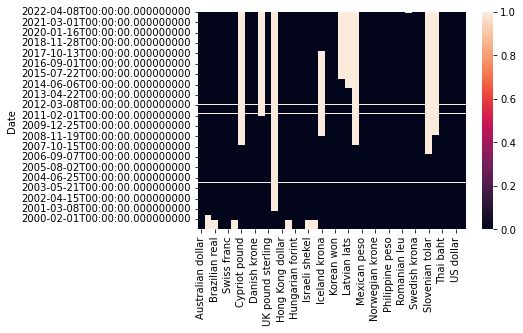

In [8]:
# Visualization of the missing values.
sns.heatmap(df.isnull());

In [9]:
#selecting null
null = df.index[df.isnull().all(1)]
print(null)
print('Number of NaN rows: {}'.format(len(null)))

DatetimeIndex(['2012-05-01', '2012-04-09', '2012-04-06', '2011-12-26',
               '2011-04-25', '2011-04-22', '2010-04-05', '2010-04-02',
               '2010-01-01', '2009-12-25', '2009-05-01', '2009-04-13',
               '2009-04-10', '2009-01-01', '2008-12-26', '2008-12-25',
               '2008-05-01', '2008-03-24', '2008-03-21', '2008-01-01',
               '2007-12-26', '2007-12-25', '2007-05-01', '2007-04-09',
               '2007-04-06', '2007-01-01', '2006-12-26', '2006-12-25',
               '2006-05-01', '2006-04-17', '2006-04-14', '2005-12-26',
               '2005-03-28', '2005-03-25', '2004-04-12', '2004-04-09',
               '2004-01-01', '2003-12-26', '2003-12-25', '2003-05-01',
               '2003-04-21', '2003-04-18', '2003-01-01', '2002-12-26',
               '2002-12-25', '2002-05-01', '2002-04-01', '2002-03-29',
               '2002-01-01', '2001-12-31', '2001-12-26', '2001-12-25',
               '2001-05-01', '2001-04-16', '2001-04-13', '2001-01-01',
      

In [10]:
df = df.drop(null)##dropping null values

In [11]:
#We will work with US Dollar because it is the biggest world currency 
Euro= df[['US dollar']]
Euro.head()

,US dollar
Date,
2022-04-08,1.0861
2022-04-07,1.0916
2022-04-06,1.0923
2022-04-05,1.0969
2022-04-04,1.1005


In [12]:
pd.plotting.register_matplotlib_converters()#modifies and adds custom converters for time
#Euro.index = Euro.index.to_timestamp()#set index again

### Time Series Decomposition

Most of Time series models assume that the data is stationary. This Process consist of separating time series data into its core components;
+ Level: The average value in the series.
+ Trend: The increasing or decreasing value in the series.
+ Seasonality: The repeating short-term cycle in the series.
+ Noise: The random variation in the series.


<a href=" https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/">J. Brownlee, 2017</a>

In [13]:
# graphs to show seasonal_decompose
def ETS_Decomposition (timeseries):
    """Plot to descompose the time series in years with a 
    multiplicative model: y(t) = Level * Trend * Seasonality * Noise"""
    
    decomposition = sm.tsa.seasonal_decompose(timeseries, model='add', freq= 365)# year show off seasonality better
                                                                               #30 days  
    
    fig = decomposition.plot()
    fig.set_size_inches(17,8)
    plt.show()
   

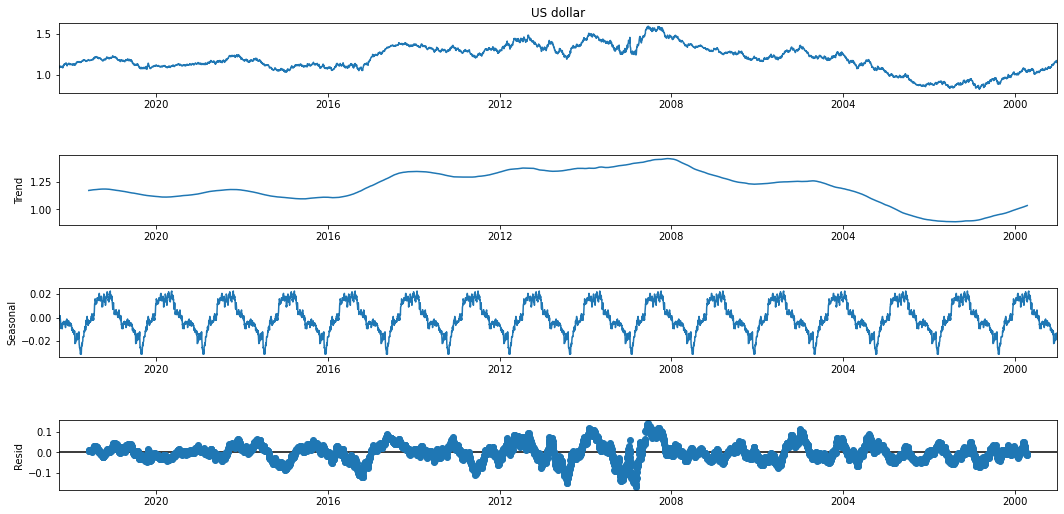

In [14]:
ETS_Decomposition (Euro['US dollar'])

### Stationality 

#### Augmented Dickey–Fuller test

Augmented Dickey–Fuller test is one of the most commonly statistical test used to check whether a given Time series is stationary or not.  

In [15]:
def ADFuller(timeseries):
    """
    Function applies the Augmented Dickey–Fuller test to the time series,
    and check the level of confidence at 99%, 95% and 90%
    
    """
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(key, value, 'not' if value < result[0] else '', 100-int(key[:-1])))

In [16]:
ADFuller(Euro['US dollar'])

ADF Statistic: -1.827750
p-value: 0.366774
Critical Values:
	1%: -3.431450071438642 - The data is not stationary with 99% confidence
	5%: -2.8620261296599536 - The data is not stationary with 95% confidence
	10%: -2.5670287644760372 - The data is not stationary with 90% confidence


#### Statistical methodology plotted

Stationarity has the property that the mean, standard deviation and autocorrelation structure do not change over time, they are constants. <a href="https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling">(E. Zvornicanin, 2021)</a>

In [17]:
### Plot for testing Stationarity with mean and standard deviation
def plot_stationarity(timeseries, title):
    '''
    
    Plot that gives a visual representation of the dataset to define its stationarity. 
    If the time series plus its mean and Standard deviation stand together it is stationary,
    if not is non-stationary.
 
    '''
    #Determing rolling statistics
    mean = pd.Series(timeseries).rolling(30).mean()#rolling a month
    std = pd.Series(timeseries).rolling(30).std()#rolling a month
    
    #setting the figure
    fig, ax = plt.subplots(figsize=(16, 4))
    #ploting
    ax.plot(timeseries, label= title)
    ax.plot(mean, label='rolling mean');
    ax.plot(std, label='rolling std');
    ax.legend()

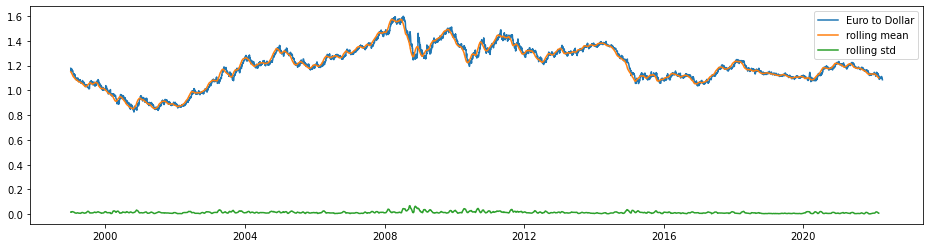

In [18]:
plot_stationarity(Euro['US dollar'], 'Euro to Dollar')

Making the dataset stationary by Detrending with rolling mean of 30 days 

ADF Statistic: -16.552643
p-value: 0.000000
Critical Values:
	1%: -3.4314532264671618 - The data is  stationary with 99% confidence
	5%: -2.862027523631579 - The data is  stationary with 95% confidence
	10%: -2.5670295065249724 - The data is  stationary with 90% confidence


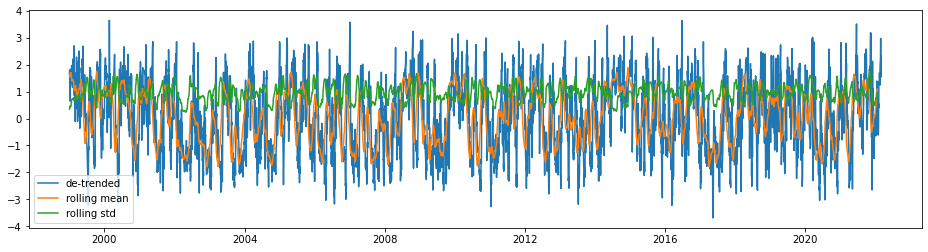

In [19]:
pd.options.mode.chained_assignment = None #to avoid SettingWithCopyWarning in Pandas
Euro['Detrend']=  (Euro['US dollar'] - Euro['US dollar'].rolling(30).mean())/Euro['US dollar'].rolling(30).std().dropna()
plot_stationarity(Euro['Detrend'],'de-trended')
ADFuller(Euro['Detrend'].dropna(inplace=False))

### Determining Parameters

#### ACF and PACF

+ Auto-Correlation Function: it describes how well the present value of the series is related with its past values.
+ Partial Auto-Correlation Function: It finds correlation of the residuals.
<a href="https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8">(J. Salvi. 2019)</a>

In [20]:
def plot_ACF_PACF(timeseries, title):
    '''
    An ACF measures the average correlation between data points in a time series
    and previous values of the series measured for different lag lengths.
    A PACF measures each partial correlation controls for any correlation between observations of a shorter lag length.
    
    '''
    #setting the figure
    plt.figure(figsize=(12,8))
    layout = (2, 2)
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    #selecting visual parameters
    timeseries.plot(ax = ax_xt)
    ax_xt.set_title(title)
    ax_xt.lines[0].set_color('blue')
    ax_xt.tick_params(axis='x', colors='green')  # 'both' refers to minor and major axes
    plot_acf(timeseries[1:], lags = 60, ax = ax_acf) # first value of diff is NaN
    ax_acf.lines[0].set_color('green')
    ax_acf.lines[1].set_color('green')
    plot_pacf(timeseries[1:], lags = 60, ax = ax_pacf) # first value of diff is NaN
    ax_pacf.lines[0].set_color('green')
    ax_pacf.lines[1].set_color('green')
    plt.tight_layout()

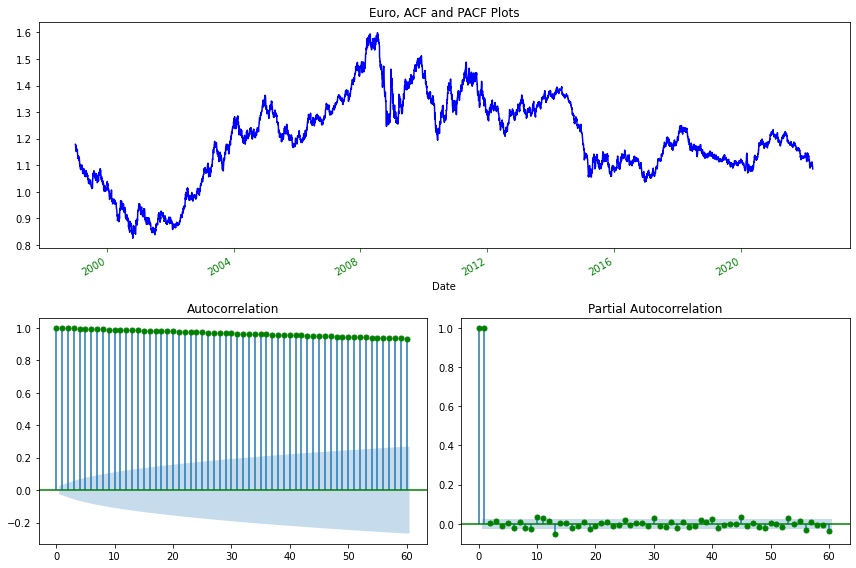

In [21]:
plot_ACF_PACF(Euro['US dollar'], 'Euro, ACF and PACF Plots')

##### Calculating the lower AIC


The Akaike information criterion (AIC) is a metric that is used to compare the fit of different regression models.

It is calculated as:

AIC = 2K – 2ln(L)

- K: The number of model parameters.
- ln(L): The log-likelihood of the model. 

This tells us how likely the model is, given the data. <a href="https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling">(E. Zvornicanin, 2021)</a>

In [22]:
# evaluate combinations of p, d and q values for an ARIMA model
aicVal=[]
p_values = range(0, 3)#AR
d_values = range(0, 3)
q_values = range(0, 3)#MA
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                arima_obj = ARIMA(Euro['US dollar'].tolist(),  order = (p,d,q))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([p, d, q, arima_obj_fit.aic])
            except:
                continue
print(aicVal)            

[[0, 0, 0, -5058.3021435750015], [0, 0, 1, -12948.276995896336], [0, 0, 2, -19329.884745173444], [0, 1, 0, -41900.110044075984], [0, 1, 1, -41898.200478189705], [0, 1, 2, -41896.799224934235], [0, 2, 0, -37739.65987398695], [0, 2, 1, -41859.47629648412], [0, 2, 2, -41857.622910161925], [1, 0, 0, -41902.83249482457], [1, 0, 1, -41900.900740020894], [1, 0, 2, -41899.44185647249], [1, 1, 0, -41898.19869785899], [1, 1, 1, -41896.19960377517], [1, 1, 2, -41896.003272884554], [1, 2, 0, -39426.9403960567], [1, 2, 1, -41877.928868568226], [1, 2, 2, -41824.00262022833], [2, 0, 0, -41900.89943621305], [2, 0, 1, -41899.44346585263], [2, 0, 2, -41898.65736921171], [2, 1, 0, -41896.80420852771], [2, 1, 1, -41896.02261083405], [2, 1, 2, -41896.542355364894], [2, 2, 0, -40179.90081734497], [2, 2, 1, -41854.124339867936], [2, 2, 2, -41876.461288805105]]


<div class="alert alert-info">For model comparison, the model with the <strong>lowest AIC score is preferred.</strong> The absolute values of the AIC scores do not matter.  These scores can be<strong> negative or positive.</strong>
    - <TT> <a href="https://stats.stackexchange.com/questions/84076/negative-values-for-aic-in-general-mixed-model">(S. Hohenstein, 2014)</a></TT>  
    </div>

#### Autoarima

Returns best ARIMA model according to either AIC, AICc or BIC value. The function conducts a search over possible model within the order constraints provided. <a href="https://www.rdocumentation.org/packages/forecast/versions/8.16/topics/auto.arima">(rdocumentation.org, n.d.)</a>


In [23]:
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              trace=True)
    return autoarima_model

In [24]:
 arimamodel(Euro['US dollar'])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41900.110, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41898.199, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-41898.200, Time=2.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41902.082, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-41895.780, Time=0.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.973 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<div class="alert alert-info"><strong>Lowest Akaike Information Criterion Results by:</strong> 
    - <TT> -> Loops [order=(1, 0, 0)] </TT>  
    - <TT> -> Autorima [order=(0, 1, 0)]</TT>  
    </div>

### Arima

AutoRegressive Integrated Moving average. It predicts future values based on past values.
+ Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged,
+ Integrated (I): represents the differencing of raw observations to allow for the time series to become stationary 
+ Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

 Parameters 
+ p: the number of lag observations in the model; also known as the lag order.
+ d: the number of times that the raw observations are differenced; also known as the degree of differencing.
+ q: the size of the moving average window; also known as the order of the moving average.
<a href="https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp#:~:text=An%20autoregressive%20integrated%20moving%20average%2C%20or%20ARIMA%2C%20is%20a%20statistical,values%20based%20on%20past%20values.">(A. Hayes, 2021)</a>

In [41]:
# Divide into train and validation 
train = Euro[:int(0.85 * (len(Euro)))]
test  = Euro[int(0.85 * (len(Euro))):]
train.shape, test.shape

((5066, 2), (894, 2))

In [65]:
n=int(len(Euro)* 0.9)#90% of the dtaset
train = list(Euro[:n]['US dollar'])
test  = list(Euro[n:]['US dollar'])
model_pred=[]
n_test_Obs =len(test)
for i in range(n_test_Obs):
    model= sm.tsa.arima.ARIMA(train, order=(1,0,0))#setting model
    model_fit=model.fit()#fitting the model
    output=model_fit.forecast()#forecasting
    yhat = output[0]#the first day prediction
    model_pred.append(yhat)#add the prediction to the model
    obs_test=test[i]#itering over the test dataset
    train.append(obs_test)#pass the historial data to the training set 

In [66]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

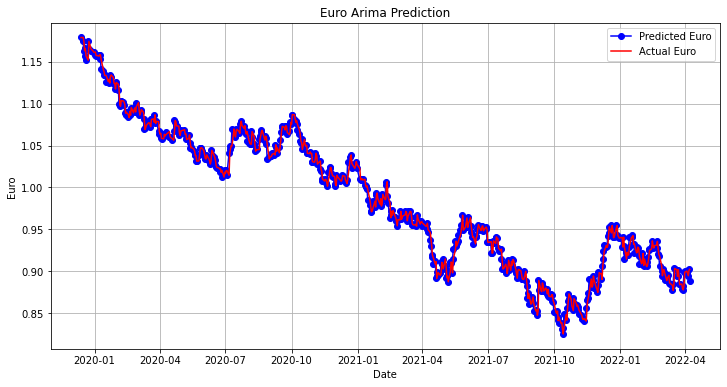

In [67]:
plt.figure(figsize=(12,6))
plt.grid(True)
date_range= Euro[:-n].index
plt.plot(date_range, model_pred,color= 'blue', marker= 'o', label ='Predicted Euro')
plt.plot(date_range,test,color= 'red', label ='Actual Euro')
plt.title('Euro Arima Prediction')
plt.xlabel('Date')
plt.ylabel('Euro')
plt.legend()
plt.show()

In [68]:
# Create a dataframe to store r2 score
R_arima_EDPR = pd.DataFrame({'r2_score': r2_score(test, model_pred)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
R_arima_EDPR ['Model'] = 'ARIMA'
R_arima_EDPR .set_index(['Model'], inplace=True)
R_arima_EDPR ['mean_absolute_error'] = mean_absolute_error(test, model_pred)
R_arima_EDPR ['mean_squared_error'] = mean_squared_error(test, model_pred)
R_arima_EDPR ['root_mean_squared_error'] = np.sqrt(mean_squared_error(test, model_pred))
R_arima_EDPR ['mean_absolute_percentage_error'] = np.mean(np.abs(np.array(model_pred) - np.array(test))
                                                               /np.abs(test))*100 
# Display the results
R_arima_EDPR 

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
Model,,,,,
ARIMA,0.992584,0.005519,0.000051,0.007172,0.570877


To do
- validation - check
- crossvalidation
- ten days forescasting

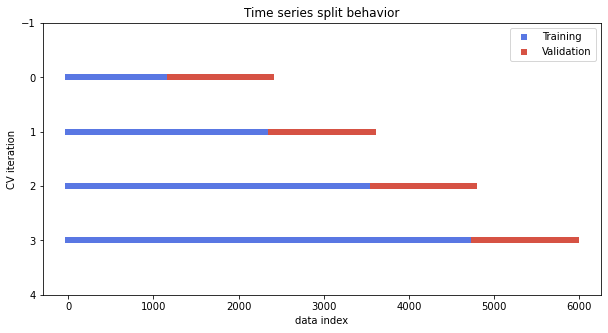

In [69]:
cv = TimeSeriesSplit(n_splits=4)
X=Euro.index
y=Euro['US dollar']

fig, ax= plt.subplots(figsize=(10,5))
for ii, (tr, tt) in enumerate(cv.split (X,y)):
    #plot training and test indices
    L1=ax.scatter(tr, [ii]* len(tr), c= [plt.cm.coolwarm(.1)], marker='_', lw=6)
    L2=ax.scatter(tt, [ii]* len(tt), c= [plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[4,-1], title= 'Time series split behavior', 
          xlabel= 'data index', ylabel= 'CV iteration')
    ax.legend([L1,L2], ['Training', 'Validation'])

In [70]:
#https://machinelearningmastery.com/make-sample-forecasts-arima-python/
#https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it/notebook
#https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

In [112]:
X=Euro.index
y=Euro['US dollar']
# Iterate through CV splits
n_splits = 4
cv = TimeSeriesSplit(n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits,0])
order=(1,0,0)

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    model_2= sm.tsa.arima.ARIMA(tr, order=order).fit()
    output=model_2.forecast()#forecasting
    coefficients[ii] = model_2.cv_results_#output[0]

AttributeError: 'ARIMAResults' object has no attribute 'cv_results_'

In [110]:

def my_pearsonr(est, X, y):
    # Generate predictions and convert to a vector
    y_pred = est.predict(X).squeeze()
    
    # Use the numpy "corrcoef" function to calculate a correlation matrix
    my_corrcoef_matrix = np.corrcoef(y_pred, y.squeeze())
    
    # Return a single correlation value from the matrix
    my_corrcoef = my_corrcoef_matrix[1, 0]
    return my_corrcoef


In [111]:
from sklearn.model_selection import cross_val_score
from functools import partial

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model_2, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

TypeError: estimator should be an estimator implementing 'fit' method, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001EC5D84DBE0> was passed

In [108]:

tscv = TimeSeriesSplit(n_splits = 4)
rmse = []
for train_index, test_index in tscv.split(df):
    start = len(train_index)
    end   = len(train_index) + len(test_index) - 1
    predictions = model.predict(start = start, end = end, dynamic = False)
    true_values = test_index
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))


TypeError: predict() missing 1 required positional argument: 'params'

In [ ]:
#https://www.projectpro.io/recipes/do-cross-validation-for-time-series